In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3,6]
wind_power_station_varphi=[1,6]
wind_power_station_v_in=[3,5]
wind_power_station_v_out=[25,25]
wind_power_station_v_r=[13,15]
wind_power_station_sigma_ue=[5,5]
wind_power_station_sigma_oe=[30,20]
wind_power_station_P_r=[160,160]
wind_power_station_P_min=[0,0]
wind_power_station_P_max=[160,160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=1
tau_robust1=np.zeros(shape=(6,1000))#每个用户在每次迭代中均需要计算出一个tau值
regularization_parameter=0.001

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=0
thermal_power_station_strategy[1][0]=0
thermal_power_station_strategy[2][0]=0
thermal_power_station_strategy[3][0]=0
wind_power_station_strategy[0][0]=0
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=0
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=-0.01

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

#计算每个发电站的邻居发电站
neighbor_robust1_help=[]
for i in range (0,6):
    for j in range (0,6):
        if E[i][j]!=0:
            neighbor_robust1_help.append(j)
        elif E[i][j]==0:
            neighbor_robust1_help.append(99)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(6,6)

#计算安全的发电站的拜占庭邻居用户数量
q_robust1=[]
for i in range(0,6):
    q_robust1_help=0
    for j in range(0,6):
        if neighbor_robust1[i][j]==5:
            q_robust1_help=q_robust1_help+1
    q_robust1.append(q_robust1_help)
    
#计算出5个诚实用户的邻居中有多少是诚实用户 有多少是拜占庭用户
neighbor_honest_num_robust1=[]
neighbor_byzantine_num_robust1=[]
for i in range(0,6):
    h_num_robust1=0
    b_num_robust1=0
    u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
    if i==0 or i==3 or i==4 or i==5:
        u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
        u_neighbor_help_robust1.remove(99)
    u_neighbor_help_robust1.remove(i)
    for j in range(0,len(u_neighbor_help_robust1)):
        if u_neighbor_help_robust1[j]==5:
            b_num_robust1=b_num_robust1+1
        else:
            h_num_robust1=h_num_robust1+1
    neighbor_honest_num_robust1.append(h_num_robust1)
    neighbor_byzantine_num_robust1.append(b_num_robust1)

In [4]:
def SCC_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        
        #SCC鲁棒聚合 安全的火力发电站的对偶更新
        for i in range (0,4):
            c_clipping_dual_robust1=[]#存放当前诚实用户对邻居的对偶变量裁剪后的值
            mix_sum_c_dual_robust1=0#存放clipping后的对偶值和
            u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
            if i==0 or i==3:
                u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
                u_neighbor_help_robust1.remove(99)
            u_neighbor_help_robust1.remove(i)
            #计算用户i在当前阶段的tau值
            if neighbor_byzantine_num_robust1[i]==0:
                tau_robust1[i][k]=10000
            else:
                weight_sum_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):
                    if u_neighbor_help_robust1[j]!=5:
                        weight_sum_robust1=weight_sum_robust1+E[i][u_neighbor_help_robust1[j]]*(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])*(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])
                tau_robust1[i][k]=sqrt(weight_sum_robust1/(E[i][5]))                       
            #每个诚实用户首先对邻居传来的对偶变量进行剪裁clipping
            for j in range (0, len(u_neighbor_help_robust1)): #问题：分母会出现0的情况
                if (dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])==0:
                    c_clipping_dual_robust1.append(0)
                elif 1<=(tau_robust1[i][k]/(abs((dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])))):
                    c_clipping_dual_robust1.append(dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])
                else:
                    c_clipping_dual_robust1.append((dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i])*((tau_robust1[i][k]/(abs((dual_variable_intermediate[u_neighbor_help_robust1[j]]-dual_variable_intermediate[i]))))))    
            #诚实用户聚合clipping后的邻居对偶值和自身的对偶值 
            for j in range(0,len(u_neighbor_help_robust1)):
                mix_sum_c_dual_robust1=mix_sum_c_dual_robust1+E[i][u_neighbor_help_robust1[j]]*(dual_variable_intermediate[i]+c_clipping_dual_robust1[j])
            #诚实用户基于SCC鲁棒聚合后的值进行自身的对偶变量的更新
            thermal_power_station_dual_variable[i][k]=E[i][i]*dual_variable_intermediate[i]+mix_sum_c_dual_robust1
        
        #聚合 安全的风力发电站的对偶更新 由于其邻居中没有拜占庭用户 所以直接按权重聚合即可
        for j in range(0,6):
            wind_power_station_dual_variable[0][k]=wind_power_station_dual_variable[0][k]+E[4][j]*dual_variable_intermediate[j]          

        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=wind_power_station_dual_variable[1][k-1]            
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
SCC_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 0.0
第 2 个火力发电站的初始计划发电量为: 0.0
第 3 个火力发电站的初始计划发电量为: 0.0
第 4 个火力发电站的初始计划发电量为: 0.0
第 5 个风力发电站的初始计划发电量为: 0.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: 0.0
第 2 个火力发电站的初始对偶变量为: 0.0
第 3 个火力发电站的初始对偶变量为: 0.0
第 4 个火力发电站的初始对偶变量为: 0.0
第 5 个风力发电站的初始对偶变量为: 0.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的初始总发电量: 0.0
*************************
需求侧用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
****************************************************************************
安全发电站

第 5 个风力发电站的对偶变量为: -77.78219078470138
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 392.4805630100068
*************************
需求侧用电需求: 79.54768147
****************************************************************************
风速分布参数c: 13.22114577
****************************************************************************
风速分布参数kappa: 2.23501543
****************************************************************************
安全发电站的总发电成本： 3065.9761370119236
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
28 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 84.54639776300395
第 2 个火力发电站的计划发电量为: 83.96681338408209
第 3 个火力发电站的计划发电量为: 66.6481393125732
第 4 个火力

48 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 61.87720404634376
第 2 个火力发电站的计划发电量为: 63.19312982008054
第 3 个火力发电站的计划发电量为: 49.00637198054612
第 4 个火力发电站的计划发电量为: 60.195773586697506
第 5 个风力发电站的计划发电量为: 61.86188697706221
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -61.21691492484211
第 2 个火力发电站的对偶变量为: -61.04151950571888
第 3 个火力发电站的对偶变量为: -60.91840496358047
第 4 个火力发电站的对偶变量为: -62.87158396616857
第 5 个风力发电站的对偶变量为: -60.984933084668704
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 296.13436641073014
*************************
需求侧用电需求: 66.51705041
****************************************************************************
风速分布参数c: 7.40752313
****************************************************************************
风速分布参数kappa: 2.00645313
***********************************************

67 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 72.58358002264006
第 2 个火力发电站的计划发电量为: 73.92797026364865
第 3 个火力发电站的计划发电量为: 58.27479895148825
第 4 个火力发电站的计划发电量为: 71.15670014179099
第 5 个风力发电站的计划发电量为: 109.20834170809334
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -65.55723287524694
第 2 个火力发电站的对偶变量为: -65.36536906505799
第 3 个火力发电站的对偶变量为: -65.22843783311815
第 4 个火力发电站的对偶变量为: -67.96476447975667
第 5 个风力发电站的对偶变量为: -65.21462507316775
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 385.1513910876613
*************************
需求侧用电需求: 69.31600221
****************************************************************************
风速分布参数c: 23.16904116
****************************************************************************
风速分布参数kappa: 2.63797045
************************************************

第 1 个火力发电站的计划发电量为: 65.29585131876324
第 2 个火力发电站的计划发电量为: 66.54396824377343
第 3 个火力发电站的计划发电量为: 53.83221996899454
第 4 个火力发电站的计划发电量为: 62.91715101290001
第 5 个风力发电站的计划发电量为: 68.92531676485696
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -72.03859730579182
第 2 个火力发电站的对偶变量为: -71.41094138583114
第 3 个火力发电站的对偶变量为: -71.42731086172574
第 4 个火力发电站的对偶变量为: -71.15110269634184
第 5 个风力发电站的对偶变量为: -72.02160854888055
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 317.51450730928815
*************************
需求侧用电需求: 70.38155319
****************************************************************************
风速分布参数c: 24.12858644
****************************************************************************
风速分布参数kappa: 2.8841721
*************************************************************

第 1 个火力发电站的计划发电量为: 64.28029732189212
第 2 个火力发电站的计划发电量为: 65.8679089903079
第 3 个火力发电站的计划发电量为: 50.812941463716705
第 4 个火力发电站的计划发电量为: 63.89646430496951
第 5 个风力发电站的计划发电量为: 62.605425940383164
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -59.809170698276304
第 2 个火力发电站的对偶变量为: -59.18356533396075
第 3 个火力发电站的对偶变量为: -59.47674351386347
第 4 个火力发电站的对偶变量为: -59.89804933772402
第 5 个风力发电站的对偶变量为: -59.91270059507164
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 307.46303802126937
*************************
需求侧用电需求: 62.36699298
****************************************************************************
风速分布参数c: 4.87322536
****************************************************************************
风速分布参数kappa: 2.17411173
***********************************************************

第 1 个火力发电站的对偶变量为: -73.80825587397241
第 2 个火力发电站的对偶变量为: -73.32192208719798
第 3 个火力发电站的对偶变量为: -73.54240928386456
第 4 个火力发电站的对偶变量为: -74.04885311229175
第 5 个风力发电站的对偶变量为: -73.8854925575636
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 353.0855956066563
*************************
需求侧用电需求: 63.68035341
****************************************************************************
风速分布参数c: 6.34912572
****************************************************************************
风速分布参数kappa: 2.09537942
****************************************************************************
安全发电站的总发电成本： 3123.0761268020897
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
************************************************************

154 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 66.9577631020685
第 2 个火力发电站的计划发电量为: 67.76614849310151
第 3 个火力发电站的计划发电量为: 53.10884519783714
第 4 个火力发电站的计划发电量为: 63.515975256192
第 5 个风力发电站的计划发电量为: 47.65950927023097
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.31612134729689
第 2 个火力发电站的对偶变量为: -66.34746476441637
第 3 个火力发电站的对偶变量为: -66.97258891540707
第 4 个火力发电站的对偶变量为: -66.06207992753399
第 5 个风力发电站的对偶变量为: -68.60432067263787
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 299.0082413194301
*************************
需求侧用电需求: 78.63672682
****************************************************************************
风速分布参数c: 19.77611549
****************************************************************************
风速分布参数kappa: 2.13009273
***************************************************

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
178 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 71.61729219388475
第 2 个火力发电站的计划发电量为: 72.7500481851137
第 3 个火力发电站的计划发电量为: 56.86959751615326
第 4 个火力发电站的计划发电量为: 69.55009737995842
第 5 个风力发电站的计划发电量为: 90.52313966979392
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -65.54522773471068
第 2 个火力发电站的对偶变量为: -65.43639036103116
第 3 个火力发电站的对偶变量为: -65.38179167127583
第 4 个火力发电站的对偶变量为: -67.44972735679977
第 5 个风力发电站的对偶变量为: -65.35039678531649
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 361.310174944904
*************************
需求侧用电需求: 72.03108923
**********************************************************************

第 2 个火力发电站的对偶变量为: -64.41929868355277
第 3 个火力发电站的对偶变量为: -64.61255760487336
第 4 个火力发电站的对偶变量为: -65.20973397503367
第 5 个风力发电站的对偶变量为: -64.9237132128262
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 309.57528782803706
*************************
需求侧用电需求: 65.97549523
****************************************************************************
风速分布参数c: 10.438951
****************************************************************************
风速分布参数kappa: 2.69416753
****************************************************************************
安全发电站的总发电成本： 2123.318781735095
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
201 次迭代中的结果：
第 1 个火力发

第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 339.2846900328333
*************************
需求侧用电需求: 74.35116785
****************************************************************************
风速分布参数c: 24.20509136
****************************************************************************
风速分布参数kappa: 2.2748069
****************************************************************************
安全发电站的总发电成本： 2902.9090703134225
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
220 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 63.845047437946874
第 2 个火力发电站的计划发电量为: 65.43620537234506
第 3 个火力发电站的计划发电量为: 51.17374578835319
第 4 个火力发电站的计划发电量为: 63.40875089613975
第 5 个风力发电站的计划发电量为: 91.1610186564959
第 6 个风力发电站的计划发电量为: 0.0
***********************

风速分布参数c: 16.98474575
****************************************************************************
风速分布参数kappa: 2.34872788
****************************************************************************
安全发电站的总发电成本： 2391.6145792481266
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
245 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 70.42644072279047
第 2 个火力发电站的计划发电量为: 71.5094770132855
第 3 个火力发电站的计划发电量为: 57.487212975294234
第 4 个火力发电站的计划发电量为: 67.4425269561832
第 5 个风力发电站的计划发电量为: 63.824573084705634
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -74.55647666415365
第 2 个火力发电站的对偶变量为: -73.01741038549099
第 3 个火力发电站的对偶变量为: -73.5101987471545
第 4 个火力发电站的对偶变量为: -72.68257426638344
第 5 个风力发电站的对偶变量为: -74.74119354972719
*******************************

第 1 个火力发电站的对偶变量为: -58.29726048160875
第 2 个火力发电站的对偶变量为: -58.130547208601904
第 3 个火力发电站的对偶变量为: -58.04841143487142
第 4 个火力发电站的对偶变量为: -61.568640611560056
第 5 个风力发电站的对偶变量为: -57.838956984470514
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 342.97493426460716
*************************
需求侧用电需求: 77.85777939
****************************************************************************
风速分布参数c: 22.22036863
****************************************************************************
风速分布参数kappa: 2.96331253
****************************************************************************
安全发电站的总发电成本： 2621.723652918107
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
*******************************************************

****************************************************************************
290 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 66.2573890899837
第 2 个火力发电站的计划发电量为: 67.7795124168641
第 3 个火力发电站的计划发电量为: 54.74248373149782
第 4 个火力发电站的计划发电量为: 64.67947713099646
第 5 个风力发电站的计划发电量为: 73.05522858552106
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -72.36440129802949
第 2 个火力发电站的对偶变量为: -71.87874800056903
第 3 个火力发电站的对偶变量为: -71.90451643623817
第 4 个火力发电站的对偶变量为: -72.04937110147796
第 5 个风力发电站的对偶变量为: -72.3497287181164
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 326.51409095486315
*************************
需求侧用电需求: 74.5481185
****************************************************************************
风速分布参数c: 23.14333577
***************************************************************************

****************************************************************************
312 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 75.59021173553585
第 2 个火力发电站的计划发电量为: 75.3894358795504
第 3 个火力发电站的计划发电量为: 59.51958019550344
第 4 个火力发电站的计划发电量为: 70.48885343810265
第 5 个风力发电站的计划发电量为: 72.54338534647053
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -71.6312577838369
第 2 个火力发电站的对偶变量为: -69.45259897103762
第 3 个火力发电站的对偶变量为: -69.87642018875567
第 4 个火力发电站的对偶变量为: -67.7751860111004
第 5 个风力发电站的对偶变量为: -71.7412836471313
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 353.5314665951629
*************************
需求侧用电需求: 69.41981789
****************************************************************************
风速分布参数c: 19.34908088
****************************************************************************

第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -61.93313569739352
第 2 个火力发电站的对偶变量为: -61.79116339572188
第 3 个火力发电站的对偶变量为: -61.69441501736891
第 4 个火力发电站的对偶变量为: -64.09184668394268
第 5 个风力发电站的对偶变量为: -61.653092354804514
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 346.3880763759414
*************************
需求侧用电需求: 71.54154034
****************************************************************************
风速分布参数c: 9.2864167
****************************************************************************
风速分布参数kappa: 2.58705886
****************************************************************************
安全发电站的总发电成本： 2611.930442769621
****************************************************************************
原变量迭代步长为: 1
**************************************************

第 2 个火力发电站的对偶变量为: -72.2057844367486
第 3 个火力发电站的对偶变量为: -72.36006633754091
第 4 个火力发电站的对偶变量为: -71.05643843292714
第 5 个风力发电站的对偶变量为: -73.57652141152732
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 348.5496678857419
*************************
需求侧用电需求: 65.82002765
****************************************************************************
风速分布参数c: 4.76734019
****************************************************************************
风速分布参数kappa: 2.61644733
****************************************************************************
安全发电站的总发电成本： 3451.86950964578
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
352 次迭代中的结果：
第 1 个火力发电

第 4 个火力发电站的计划发电量为: 67.82936332187965
第 5 个风力发电站的计划发电量为: 91.97164223252842
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.03562571245676
第 2 个火力发电站的对偶变量为: -69.83071746118165
第 3 个火力发电站的对偶变量为: -69.69209029626371
第 4 个火力发电站的对偶变量为: -71.0064542153503
第 5 个风力发电站的对偶变量为: -69.9078520208528
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 362.93665365621627
*************************
需求侧用电需求: 69.20561564
****************************************************************************
风速分布参数c: 15.12839165
****************************************************************************
风速分布参数kappa: 2.26418146
****************************************************************************
安全发电站的总发电成本： 2585.050728780793
*****************************************************************

需求侧用电需求: 78.16953212
****************************************************************************
风速分布参数c: 10.6230677
****************************************************************************
风速分布参数kappa: 2.32265741
****************************************************************************
安全发电站的总发电成本： 2482.49972096864
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
398 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 59.56475305693764
第 2 个火力发电站的计划发电量为: 61.183971510078806
第 3 个火力发电站的计划发电量为: 48.38449206905962
第 4 个火力发电站的计划发电量为: 60.14835303325812
第 5 个风力发电站的计划发电量为: 101.9790971874439
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -60.057744943172274
第 2 个火力发电站的对偶变量为: -59.86293981908069
第 3 个火力发电站的对偶变量为: -59.79841110605057
第 4 个火力

第 5 个风力发电站的计划发电量为: 91.83218082366716
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -62.48409025663936
第 2 个火力发电站的对偶变量为: -62.413801437612136
第 3 个火力发电站的对偶变量为: -62.38197849875063
第 4 个火力发电站的对偶变量为: -64.85183843692592
第 5 个风力发电站的对偶变量为: -62.2381574518889
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 357.3588192755552
*************************
需求侧用电需求: 69.39661248
****************************************************************************
风速分布参数c: 4.00348291
****************************************************************************
风速分布参数kappa: 2.33870845
****************************************************************************
安全发电站的总发电成本： 4174.7493898648245
****************************************************************************
原变量迭代步长为: 1
************

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
451 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 62.379651208507795
第 2 个火力发电站的计划发电量为: 64.00172079455749
第 3 个火力发电站的计划发电量为: 50.59390272677655
第 4 个火力发电站的计划发电量为: 61.62049829580034
第 5 个风力发电站的计划发电量为: 88.41870588409228
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -65.22998144106592
第 2 个火力发电站的对偶变量为: -65.1150973050942
第 3 个火力发电站的对偶变量为: -65.06448181042273
第 4 个火力发电站的对偶变量为: -66.99855411828773
第 5 个风力发电站的对偶变量为: -65.01931499080169
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 327.0144789097344
*************************
需求侧用电需求: 67.05431856
********************************************************************

第 5 个风力发电站的对偶变量为: -71.5197892962041
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 311.1941205217718
*************************
需求侧用电需求: 67.54839127
****************************************************************************
风速分布参数c: 14.18041654
****************************************************************************
风速分布参数kappa: 2.32874634
****************************************************************************
安全发电站的总发电成本： 2087.918158295656
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
471 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 63.68181557680377
第 2 个火力发电站的计划发电量为: 65.17244707631644
第 3 个火力发电站的计划发电量为: 52.51650416076214
第 4 个火力

安全发电站的总发电成本： 3028.266522013999
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
491 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 71.92266049629144
第 2 个火力发电站的计划发电量为: 73.06031620605748
第 3 个火力发电站的计划发电量为: 56.965245869688054
第 4 个火力发电站的计划发电量为: 69.65312142799762
第 5 个风力发电站的计划发电量为: 92.48462317194327
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -64.16372136827431
第 2 个火力发电站的对偶变量为: -63.98329556025805
第 3 个火力发电站的对偶变量为: -63.858001360707455
第 4 个火力发电站的对偶变量为: -65.74012140009086
第 5 个风力发电站的对偶变量为: -63.960806890913325
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 364.08596717197787
***

第 5 个风力发电站的计划发电量为: 63.733891554713395
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.92439974062653
第 2 个火力发电站的对偶变量为: -68.55700088421932
第 3 个火力发电站的对偶变量为: -68.88226695501463
第 4 个火力发电站的对偶变量为: -67.85936600369423
第 5 个风力发电站的对偶变量为: -70.00941234908257
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 316.1906706954983
*************************
需求侧用电需求: 77.01716214
****************************************************************************
风速分布参数c: 20.41572577
****************************************************************************
风速分布参数kappa: 2.04193611
****************************************************************************
安全发电站的总发电成本： 2502.7662202335455
****************************************************************************
原变量迭代步长为: 1
**********

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
541 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 65.80623007454801
第 2 个火力发电站的计划发电量为: 66.20692018215199
第 3 个火力发电站的计划发电量为: 52.64366439490497
第 4 个火力发电站的计划发电量为: 61.93026682110387
第 5 个风力发电站的计划发电量为: 65.05396595204695
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -68.20320924765241
第 2 个火力发电站的对偶变量为: -66.87747370238081
第 3 个火力发电站的对偶变量为: -67.0070630805927
第 4 个火力发电站的对偶变量为: -65.63291895572569
第 5 个风力发电站的对偶变量为: -68.21331362663747
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 311.64104742475575
*************************
需求侧用电需求: 67.03343727
********************************************************************

*************************
需求侧用电需求: 65.22711041
****************************************************************************
风速分布参数c: 9.97883277
****************************************************************************
风速分布参数kappa: 2.24140062
****************************************************************************
安全发电站的总发电成本： 2506.452531619627
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
564 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 70.76959314587799
第 2 个火力发电站的计划发电量为: 72.21323524609116
第 3 个火力发电站的计划发电量为: 57.15694124395333
第 4 个火力发电站的计划发电量为: 69.24876923606605
第 5 个风力发电站的计划发电量为: 71.85317550444138
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.07011609430918
第 2 个火力发电站的对偶变量为: -68.7571900551165
第 3 个火力发电站的对偶变量为: -6

第 2 个火力发电站的计划发电量为: 69.68094552440058
第 3 个火力发电站的计划发电量为: 55.40150340886093
第 4 个火力发电站的计划发电量为: 65.82475831605694
第 5 个风力发电站的计划发电量为: 77.43307377750267
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.70180667841552
第 2 个火力发电站的对偶变量为: -70.08536674738907
第 3 个火力发电站的对偶变量为: -69.91500634949014
第 4 个火力发电站的对偶变量为: -69.82964641999256
第 5 个风力发电站的对偶变量为: -70.57470137593924
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 337.05930578003137
*************************
需求侧用电需求: 60.90398115
****************************************************************************
风速分布参数c: 16.84056871
****************************************************************************
风速分布参数kappa: 2.26830573
****************************************************************************
安全发电站的总发电成本： 2433.72

原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
616 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 63.57854581065508
第 2 个火力发电站的计划发电量为: 65.21437385237195
第 3 个火力发电站的计划发电量为: 51.49818729029604
第 4 个火力发电站的计划发电量为: 63.549169346872304
第 5 个风力发电站的计划发电量为: 95.43360525891688
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -63.70891580972089
第 2 个火力发电站的对偶变量为: -63.56659537635953
第 3 个火力发电站的对偶变量为: -63.47886172788313
第 4 个火力发电站的对偶变量为: -66.18180290770528
第 5 个风力发电站的对偶变量为: -63.37379793266944
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 339.2738815591123
*************************
需求侧用电需求: 75.62523711
*******************************************************************

第 2 个火力发电站的对偶变量为: -66.43429781813082
第 3 个火力发电站的对偶变量为: -66.5163535520325
第 4 个火力发电站的对偶变量为: -67.96916782710167
第 5 个风力发电站的对偶变量为: -66.5043119937821
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 350.063277257049
*************************
需求侧用电需求: 72.64609351
****************************************************************************
风速分布参数c: 17.46505535
****************************************************************************
风速分布参数kappa: 2.50027166
****************************************************************************
安全发电站的总发电成本： 2530.6940001342073
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
636 次迭代中的结果：
第 1 个火力发

****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
657 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 62.329090042361585
第 2 个火力发电站的计划发电量为: 63.7054480668495
第 3 个火力发电站的计划发电量为: 50.82512990362501
第 4 个火力发电站的计划发电量为: 61.0117574983267
第 5 个风力发电站的计划发电量为: 36.37624006872782
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -70.49699131684326
第 2 个火力发电站的对偶变量为: -69.19731415559012
第 3 个火力发电站的对偶变量为: -69.55065289645616
第 4 个火力发电站的对偶变量为: -68.67864378010836
第 5 个风力发电站的对偶变量为: -70.61732772046427
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 274.2476655798906
*************************
需求侧用电需求: 74.8

对偶变量迭代步长为: 1
****************************************************************************
683 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 58.58078617612036
第 2 个火力发电站的计划发电量为: 60.14817707903742
第 3 个火力发电站的计划发电量为: 46.437937013559285
第 4 个火力发电站的计划发电量为: 58.620117512040395
第 5 个风力发电站的计划发电量为: 87.34203932382293
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -57.21425741976035
第 2 个火力发电站的对偶变量为: -57.05554280098755
第 3 个火力发电站的对偶变量为: -56.95883568982198
第 4 个火力发电站的对偶变量为: -59.3164567068399
第 5 个风力发电站的对偶变量为: -56.92324245070927
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 311.1290571045804
*************************
需求侧用电需求: 72.2446366
****************************************************************************
风速分布参数c: 14.11699691
***********************************************************

第 3 个火力发电站的对偶变量为: -72.8399900172132
第 4 个火力发电站的对偶变量为: -71.95105997639399
第 5 个风力发电站的对偶变量为: -73.88319477065654
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 352.84365454946203
*************************
需求侧用电需求: 71.64215386
****************************************************************************
风速分布参数c: 9.26686397
****************************************************************************
风速分布参数kappa: 2.39883923
****************************************************************************
安全发电站的总发电成本： 2677.823328768461
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
710 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 73.01523382353726
第 2 个火力

739 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 72.5254415244614
第 2 个火力发电站的计划发电量为: 72.55062132091994
第 3 个火力发电站的计划发电量为: 58.135376684836736
第 4 个火力发电站的计划发电量为: 67.47425155345387
第 5 个风力发电站的计划发电量为: 54.40360338753173
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -74.00407124168746
第 2 个火力发电站的对偶变量为: -72.49952130893706
第 3 个火力发电站的对偶变量为: -72.77177809163658
第 4 个火力发电站的对偶变量为: -71.41131072261399
第 5 个风力发电站的对偶变量为: -74.0592935167878
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 325.0892944712037
*************************
需求侧用电需求: 72.69007882
****************************************************************************
风速分布参数c: 3.8377808
****************************************************************************
风速分布参数kappa: 2.57153473
***************************************************

第 4 个火力发电站的对偶变量为: -68.30618652000167
第 5 个风力发电站的对偶变量为: -73.13448956735948
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 291.1197685435739
*************************
需求侧用电需求: 74.1998968
****************************************************************************
风速分布参数c: 8.00343276
****************************************************************************
风速分布参数kappa: 2.8290435
****************************************************************************
安全发电站的总发电成本： 2002.3408390182535
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
769 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 67.34256166005721
第 2 个火力发电站的计划发电量为: 67.27114373850523
第 3 个火力发

第 3 个火力发电站的对偶变量为: -65.7476259016292
第 4 个火力发电站的对偶变量为: -66.44088705218296
第 5 个风力发电站的对偶变量为: -66.16452124306164
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 313.50642661041053
*************************
需求侧用电需求: 73.02780591
****************************************************************************
风速分布参数c: 3.53356769
****************************************************************************
风速分布参数kappa: 2.2320454
****************************************************************************
安全发电站的总发电成本： 3193.9558787665283
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
799 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 67.22725670450075
第 2 个火力

****************************************************************************
安全发电站的总发电成本： 3225.8182064753873
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
819 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 71.49890881014124
第 2 个火力发电站的计划发电量为: 72.29902657798577
第 3 个火力发电站的计划发电量为: 56.719908567151464
第 4 个火力发电站的计划发电量为: 69.29524561869054
第 5 个风力发电站的计划发电量为: 114.36946806829866
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -62.84761743640151
第 2 个火力发电站的对偶变量为: -62.70783922772847
第 3 个火力发电站的对偶变量为: -62.60361542175047
第 4 个火力发电站的对偶变量为: -66.49468543971719
第 5 个风力发电站的对偶变量为: -62.362169007556396
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
*********************************

****************************************************************************
安全发电站的总发电量: 317.54510052824025
*************************
需求侧用电需求: 72.76555814
****************************************************************************
风速分布参数c: 11.97124631
****************************************************************************
风速分布参数kappa: 2.06408043
****************************************************************************
安全发电站的总发电成本： 2211.5337239867395
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
846 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 59.630977045349475
第 2 个火力发电站的计划发电量为: 61.288956956899845
第 3 个火力发电站的计划发电量为: 48.634768417405496
第 4 个火力发电站的计划发电量为: 60.47098608129962
第 5 个风力发电站的计划发电量为: 85.82963590144607
第 6 个风力发电站的计划发电量为: 0.0
*********************************************************

需求侧用电需求: 73.35520701
****************************************************************************
风速分布参数c: 6.98295513
****************************************************************************
风速分布参数kappa: 2.66921228
****************************************************************************
安全发电站的总发电成本： 2155.566813999705
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
870 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 59.74540429403543
第 2 个火力发电站的计划发电量为: 61.42786439838835
第 3 个火力发电站的计划发电量为: 48.79131336134674
第 4 个火力发电站的计划发电量为: 59.783482322873056
第 5 个风力发电站的计划发电量为: 55.074213791938085
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -62.94233388689448
第 2 个火力发电站的对偶变量为: -62.776893710589555
第 3 个火力发电站的对偶变量为: -62.90023853972087
第 4 个

895 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 70.04745702893781
第 2 个火力发电站的计划发电量为: 71.48310864260294
第 3 个火力发电站的计划发电量为: 55.88992878009579
第 4 个火力发电站的计划发电量为: 69.05055535446823
第 5 个风力发电站的计划发电量为: 112.99344507278927
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -63.27144371905522
第 2 个火力发电站的对偶变量为: -63.09899802308827
第 3 个火力发电站的对偶变量为: -62.99990530637286
第 4 个火力发电站的对偶变量为: -66.46215676394785
第 5 个风力发电站的对偶变量为: -62.827924315142894
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 379.4644948788941
*************************
需求侧用电需求: 72.91210759
****************************************************************************
风速分布参数c: 21.50646833
****************************************************************************
风速分布参数kappa: 2.77971978
**********************************************

第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 364.21372734710405
*************************
需求侧用电需求: 66.36067078
****************************************************************************
风速分布参数c: 8.60313232
****************************************************************************
风速分布参数kappa: 2.47756525
****************************************************************************
安全发电站的总发电成本： 3007.979356622867
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
921 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 69.2185948502355
第 2 个火力发电站的计划发电量为: 70.52539961122383
第 3 个火力发电站的计划发电量为: 56.212050144139425
第 4 个火力发电站的计划发电量为: 67.39086229041668
第 5 个风力发电站的计划发电量为: 91.5443802934918
第 6 个风力发电站的计划发电量为: 0.0
************************

第 2 个火力发电站的计划发电量为: 72.95440749903756
第 3 个火力发电站的计划发电量为: 57.53681657539284
第 4 个火力发电站的计划发电量为: 69.65132214470181
第 5 个风力发电站的计划发电量为: 85.91735311499495
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -69.24924077154941
第 2 个火力发电站的对偶变量为: -69.02564261662097
第 3 个火力发电站的对偶变量为: -68.92564307453607
第 4 个火力发电站的对偶变量为: -70.35592317188728
第 5 个风力发电站的对偶变量为: -69.12057480930524
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 357.7324391248413
*************************
需求侧用电需求: 74.52830708
****************************************************************************
风速分布参数c: 12.47160928
****************************************************************************
风速分布参数kappa: 2.216164
****************************************************************************
安全发电站的总发电成本： 2582.36481

第 5 个风力发电站的计划发电量为: 48.515397527532464
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -73.6060024260571
第 2 个火力发电站的对偶变量为: -71.53842894681208
第 3 个火力发电站的对偶变量为: -72.0678207620332
第 4 个火力发电站的对偶变量为: -70.72383274943147
第 5 个风力发电站的对偶变量为: -73.89844436263427
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 311.991358530524
*************************
需求侧用电需求: 68.97563814
****************************************************************************
风速分布参数c: 6.24681982
****************************************************************************
风速分布参数kappa: 2.84273613
****************************************************************************
安全发电站的总发电成本： 2349.215258071041
****************************************************************************
原变量迭代步长为: 1
***************

第 3 个火力发电站的对偶变量为: -72.03012133399417
第 4 个火力发电站的对偶变量为: -69.09288204091688
第 5 个风力发电站的对偶变量为: -75.0526480481395
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 334.65830829278474
*************************
需求侧用电需求: 67.46785371
****************************************************************************
风速分布参数c: 10.91176004
****************************************************************************
风速分布参数kappa: 2.64243598
****************************************************************************
安全发电站的总发电成本： 2397.510194765007
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
994 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 75.23604034921597
第 2 个火

In [6]:
#数据存储
np.savetxt('./data/04_SCC_optimal_parameters_large_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/04_SCC_optimal_parameters_large_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/04_SCC_optimal_parameters_large_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret_T

[-1203.6743223,
 -1458.1681773,
 -1589.6554169233332,
 -1524.405142215,
 -1550.96961742,
 -1502.3869041466667,
 -1503.1314617914286,
 -1461.176103075,
 -1401.4006409044443,
 -1474.8224966419998,
 -1450.4705158290908,
 -1363.3491786925,
 -1312.0043837423075,
 -1246.74939555,
 -1151.9336797266665,
 -1084.1404251506249,
 -1001.4764405329411,
 -911.8281070127775,
 -828.4676984284208,
 -767.6142955269999,
 -703.5549386252378,
 -620.0026581781815,
 -568.9264077821737,
 -516.6960963316664,
 -455.7109259827997,
 -429.7500991046152,
 -409.8950202903702,
 -373.2837730899999,
 -345.393947889655,
 -307.6874677166665,
 -278.40532838225795,
 -264.4822018871874,
 -248.95447490757562,
 -234.72693642117633,
 -201.342642222857,
 -186.76699388138874,
 -180.72542822621608,
 -152.36073518526302,
 -136.60352284410243,
 -126.47273688474988,
 -121.8218834592682,
 -125.6797911199999,
 -110.14908165976735,
 -112.13657178068173,
 -112.69588658177769,
 -111.46838532586949,
 -98.37076360489354,
 -103.8631940756249

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

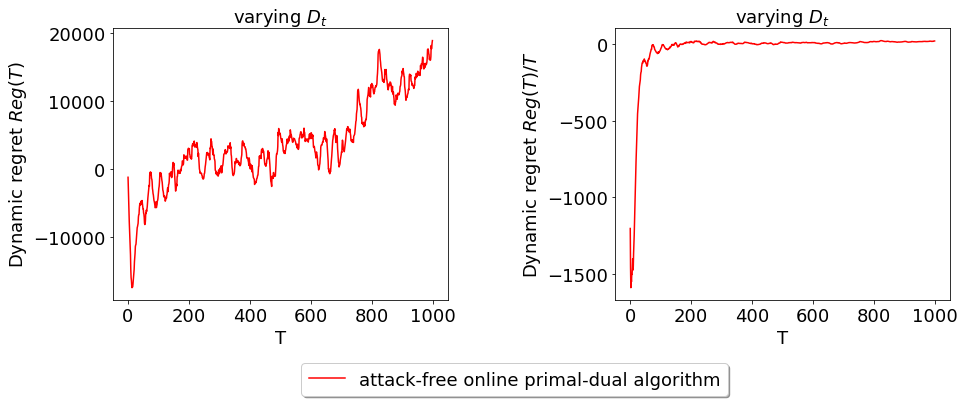

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/04_SCC_optimal_parameters_large_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation_T

[44.659041904000006,
 48.588688235000006,
 50.17187312533334,
 50.619864112500004,
 50.137804175999996,
 49.242723363,
 48.25225094428572,
 45.9568785035,
 44.248590002444445,
 43.955967025199996,
 42.82165761636364,
 40.35663758183333,
 38.39883960338461,
 36.58456519385714,
 34.181696299733325,
 32.14180236162499,
 30.49598145247058,
 28.869287940333322,
 26.768588438947358,
 25.221300161699986,
 23.819211931904746,
 22.41754210945453,
 21.202551417999985,
 20.242512622749985,
 18.862933187119985,
 18.1123061513846,
 17.48042699274073,
 16.5470197127857,
 15.826667424551712,
 14.96996706733332,
 14.166985873225793,
 13.883967588812487,
 13.367140902484836,
 12.917277009823517,
 12.304473539199988,
 11.876677208444432,
 11.55143890189188,
 10.808141925999987,
 10.419825825384603,
 10.225524082499987,
 10.01870651141462,
 10.086375711428557,
 10.001577183860451,
 9.86813735722726,
 9.775637730844432,
 9.644620530608682,
 9.622259467702115,
 9.573674418958321,
 9.671922324734682,
 9.715

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

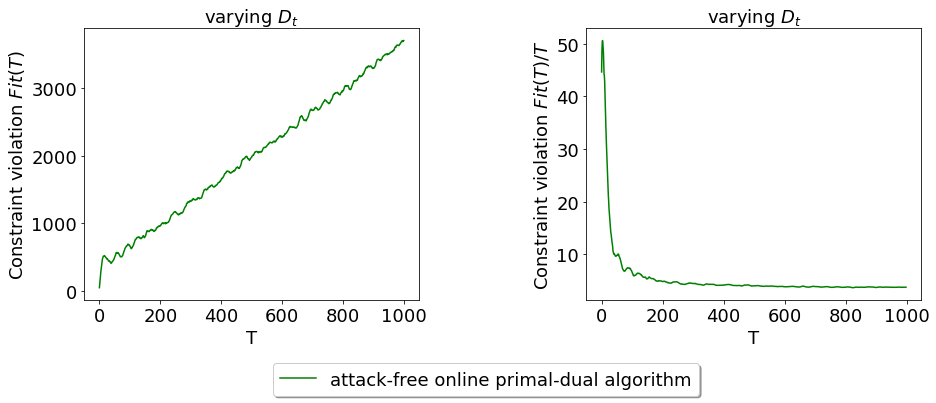

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')